# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 1 - Supervised Deep Learning

# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Libraries

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
#from sklearn.model_selection import KFold

In [47]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


## Dataset
***

Before downloading the datasets I define a composed transformation to be applied on the elements of the dataset. The data are transformed to tensors and normalized such that their values goes from -1 to 1.

In [48]:
initial_transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(0.5,0.5)])

In [49]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=initial_transform)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=initial_transform)

How to get an image and the corresponding label:

SAMPLE AT INDEX 0
LABEL: 9


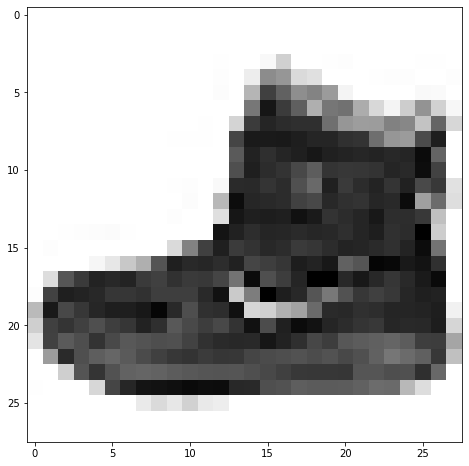

In [50]:
sample_index = 0
image = train_dataset[sample_index][0].squeeze().numpy()
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

## Network Definition
***

Here I define a Convolutional Neural Network, and its functions to train and test the model.
The classificator is composed of:
* First convolutional block, a `Conv2d` with 1 channel in input (images are grayscale) and Ch1 channels in output. 4x4 kernel, stride=2, padding=2 to reduce the sample size from 28x28 to 15x15. The output is normalized with a `BatchNorm2d` layer and feed to a `ReLU` activation function.
* Second convolutional block, a `Conv2d` with Ch1 channel in input and Ch2 channels in output. 5x5 kernel, stride=3, padding=1 to reduce the sample size from 15x15 to 5x5 . The output is normalized with a `BatchNorm2d` layer and feed to a `ReLU` activation function.
* Fully connected block: a flatten layer (5x5xCh2 neuron), a fully connected hidden layer with Nh neurons, activated by a `ReLU`, followed by a `Dropout` layer the output layer with 10 neurons. (as the number of classes)

The Batch Normalization is used to rescale the data in a [-1,1] range.

In [51]:
class ConvNet(nn.Module):
    
    def __init__(self, Ch1, Ch2, Nh, drop):
        """
        Ch1  - Out channels of the 1st convolutional layer
        Ch2  - Out channels of the 2nd convolutional layer
        Nh   - Neurons in the fc hidden layer
        drop - Dropout probability of the fc hiddem layer
        """
        super().__init__()
        
        print('Network initialized')
        flatten_dim = 5*5*Ch2
        self.convBlock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=Ch1, kernel_size=4, stride=2, padding=2, padding_mode='replicate'), #15x15
            nn.BatchNorm2d(Ch1),
            nn.ReLU()
        )
        
        self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels=Ch1, out_channels=Ch2, kernel_size=5, stride=3, padding=1, padding_mode='replicate'), #5x5
            nn.BatchNorm2d(Ch2),
            nn.ReLU()
        )
        
        self.fcBlock = nn.Sequential(
            nn.Linear(in_features=flatten_dim, out_features=Nh),
            nn.Dropout(p=drop),
            nn.ReLU(),
            nn.Linear(in_features=Nh, out_features=10)
        )
                
    def forward(self, x):
        
        x = self.convBlock1(x)
        x = self.convBlock2(x)
        x = torch.flatten(x,1)
        x = self.fcBlock(x)
        return x
    
    def train_epoch(self, train_dataloader, device, loss_fn, optimizer):
        '''
        train_dataloader - DataLoader containing the training data
        device           - torch.device
        loss_fn          - loss function torch.nn.modules.loss
        optimizer        - torch.optim
        ---
        RETURN           - float: training loss
        '''
        train_loss = []
        for sample_batched in train_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = self(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Backpropagation
            self.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
        train_loss = np.mean(train_loss)
        return train_loss
        
    def eval_epoch(self, val_dataloader, device, loss_fn):
        '''
        val_dataloader - DataLoader containing the validation data
        device         - torch.device
        loss_fn        - loss function torch.nn.modules.loss
        ---
        RETURN         - float: validation loss
        '''
        val_loss = []
        for sample_batched in val_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = self(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
        val_loss = np.mean(val_loss)
        return val_loss
    
    def run_training(self, train_dataset, param_dict, val_dataset=None, plot=False):
        '''
        TRAIN THE MODEL WITH(OUT) VALIDATION
        -----
        train_dataset - DataSet containing the training data
        param_dict    - Dictionary of parameter. 
                        keys:{'epoch','device','loss_fn','optimizer'}
        val_dataset   - *DataSet: containing the validation data
                        *float: percentage of training data to use as validation
                        *None: (default) do not use validation data
        plot          - Bool: If True plot loss vs epochs
        -----
        RETURN        - lists of training and validation loss
        '''
        val_present = True
        if isinstance(val_dataset, float):
            N_val = int(len(train_dataset)*val_dataset)
            train_dataset, val_dataset = random_split(train_dataset, 
                                         lengths=[len(train_dataset)-N_val, N_val], 
                                         generator=torch.Generator().manual_seed(42))
            val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=0)
            train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
        elif isinstance(val_dataset, CsvDataset):
            val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True, num_workers=0)
            train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
        elif isinstance(val_dataset, DataLoader):
            val_dataloader  = val_dataset
            train_dataloader = train_dataset
        elif (val_dataset is None):
            val_present = False
            train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
        else:
            print('val_dataset not valid')
        
        self.to(param_dict['device'])
        train_loss_log = ['---']
        val_loss_log = ['---']
        print('AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH')
        epochs = tqdm(range(param_dict['epochs']), leave=True)
        # LOOP START
        for epoch in epochs:
            epochs.set_description("%s         %s       %s" % (train_loss_log[-1], val_loss_log[-1], epoch))
            
            # Training
            self.train()
            train_loss = self.train_epoch(train_dataloader, param_dict['device'],
                                          param_dict['loss_fn'], param_dict['optimizer'])
            train_loss_log.append(train_loss)
            
            # Evaluation
            self.eval()
            val_loss = self.eval_epoch(val_dataloader, param_dict['device'], param_dict['loss_fn'])
            val_loss_log.append(val_loss)
            
        # Plotting
        if plot:
            plt.figure(figsize=(12,8))
            plt.semilogy(train_loss_log[1:], label='Train loss')
            if val_present: plt.semilogy(val_loss_log[1:], label='Validation loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.grid()
            plt.legend()
            plt.show()
        return train_loss_log[1:], val_loss_log[1:]
    
    def run_test(self, test_dataset, param_dict):
        '''
        TEST THE MODEL
        -----
        test_dataset - DataSet containing the test data
        param_dict   - Dictionary of parameter. 
                       keys:{'device','loss_fn'}
        -----
        RETURN       - np.array: predicted labels
                     - float: loss of predicted vs true label
        '''
        test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
        self.eval()
        with torch.no_grad(): # turn off gradients computation
            label_list = []
            pred_list = []
            for sample_batched in test_dataloader:
                # Move data to device
                x_batch = sample_batched[0].to(param_dict['device'])
                label_batch = sample_batched[1].detach().cpu().numpy()

                # Forward pass
                out = self(x_batch)
                pred_batch = out.detach().cpu().numpy().argmax(1)
                label_list.append(label_batch)
                pred_list.append(pred_batch)
                
        print(f'Accuracy of the network on the 10000 test images: {100 * np.equal(label_list,pred_list).sum() // len(pred_list)} %')
        return pred_list, label_list

def reset_weights(model):
    if isinstance(model, nn.Linear):
        model.reset_parameters()

def confusion_matrix(foo, bar):
    out = np.zeros((10,10))
    for i,j in zip(foo,bar):
        out[i,j] +=1
    return out/len(foo)

## Trial Network
***

Now I define and train a simple network to test if everything works fine.
The network's convolutional layer maps the data into 4 and 16 channels respectively.
The fully connected hidden layer has 100 neurons wich are turned of with a dropout probability of 15%
I also produce `trial_params` dictionary, in order to store:
* number of epoch
* device
* loss function (CrossEntropyLoss)
* optimizer (in this test will be Adam)

In [52]:
trial_net = ConvNet(4,16,100,0.15)

Network initialized


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.29607645         0.30733395       3: 100%|██████████| 4/4 [01:39<00:00, 24.87s/it]


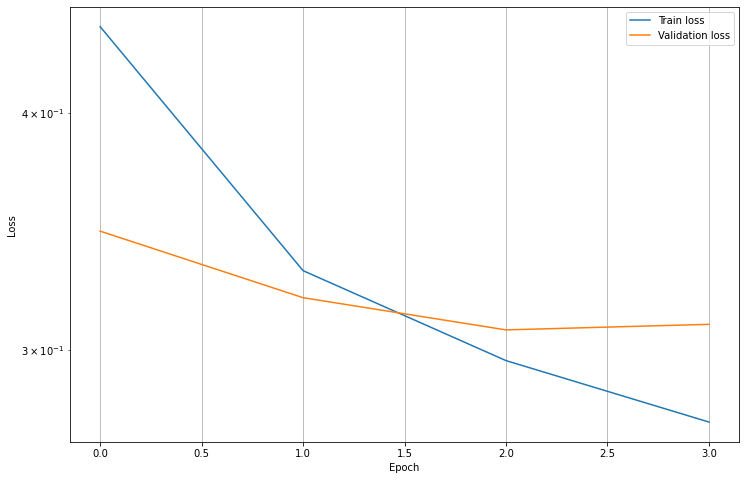

In [53]:
trial_params = {'epochs' : 4,
                'device' : device,
                'loss_fn' : nn.CrossEntropyLoss(),
                'optimizer' : optim.Adam(trial_net.parameters(), lr=1e-3)}
_, _ = trial_net.run_training(train_dataset, trial_params, val_dataset=0.2, plot=True)

In [55]:
trial_predict, trial_label = trial_net.run_test(test_dataset, trial_params)

Accuracy of the network on the 10000 test images: 88 %


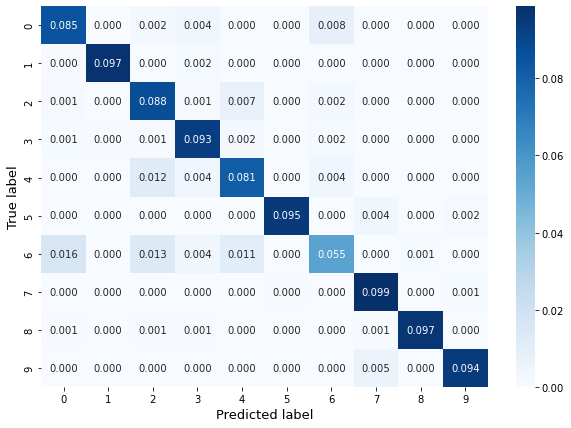

In [58]:
plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix(trial_label, trial_predict), annot=True, fmt =  "1.3f" , cmap="Blues" )
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

The network has reach an accuracy of 88%. It is already a good result, but I try to improve the performances optimizing the hyperparameters.


## Hyperparameter Tuning
***
Now I want to find the best set of hyperparameter for the model, so I will perform a (random) GridSearch on:
* Convolutional channels
* Hidden neurons
* Dropout probability
* Weight regularization
* Learning Rate
* optimizer

Since the training data are a lot I didn't implemented a K-fold Cross Validation setup, I silmply produce a validation dataset taking the 20% of the training data.

In [11]:
def HPSampler(hp_dict):
    out = dict()
    for key, value in hp_dict.items():
        out[key] = np.random.choice(value)
    return out

def ModelFromHP(net_model, hyper_param, device):
    '''
    Initialize the Network and build the parameter dictionary
    ---
    net_model     - nn.Module
    hyper_param - dictionary with the actual hyperparameter
    device      - torch.device
    '''
    Ch1  = hyper_param['Ch1']
    Ch2  = hyper_param['Ch2']
    Nh   = hyper_param['Nh']
    drop = hyper_param['drop']
    wd   = hyper_param['wd']
    lr   = hyper_param['lr']
    ep   = hyper_param['epochs']
    ## Network Initialization
    actual_net = net_model(Ch1,Ch2,Nh,drop)
    
    if (hyper_param['optim'] == 'sgd'):
        optimizer = optim.SGD(actual_net.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    elif (hyper_param['optim'] == 'adam'):
        optimizer = optim.Adam(actual_net.parameters(), lr=lr, weight_decay=wd)
    else :
        print('Wrong optimizer')
    return actual_net, {'epochs' : ep,
                        'device' : device,
                        'loss_fn' : nn.CrossEntropyLoss(),
                        'optimizer' : optimizer}

def GridSearch(net_model, train_dataset, hp_dict, N, device):
    '''
    RANDOM GRID SEARCH with K-Fold CROSS VALIDATION
    -----
    net_model     - nn.Module
    train_dataset - DataSet containing the training data
    hp_dict       - dictionary of the hyperparameter on 
                    which perform grid search
    N             - number of different configuration to try
    device        - torch.device
    '''
    models = []
    best_loss = 1000
    for config in range(N):
        # Sample the hyperparameter configuration
        actual_hp = HPSampler(hp_dict)
        # Initialize the net
        actual_net, actual_params = ModelFromHP(net_model, actual_hp, device)
        # Train the model
        train_loss, val_loss = actual_net.run_training(train_dataset, actual_params, val_dataset=0.2, plot=False)

        if (val_loss[-1] < best_loss): 
            best_loss = val_loss[-1]
            best_model = config
        models.append({'hp_dict'   : actual_hp,
                       'train_loss': train_loss,
                       'val_loss'  : val_loss})
    return models, best_model

In [15]:
hyper_dict = {'Ch1'   : [4,8], 
              'Ch2'   : [16,32],
              'Nh'    : [62,128,256],
              'drop'  : np.linspace(0.1,0.5,100),
              'wd'    : np.logspace(-4,-2,100),
              'lr'    : np.logspace(-4,-2,100),
              'optim' : ['sgd', 'adam'],
              'epochs': [10]}

In [ ]:
model_list, best_model = GridSearch(ConvNet, train_dataset, hyper_dict, 20, device)

Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.35084248         0.35052958       9: 100%|██████████| 10/10 [03:38<00:00, 21.82s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.34572223         0.3098017       9: 100%|██████████| 10/10 [04:06<00:00, 24.61s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.26514336         0.27120858       9: 100%|██████████| 10/10 [03:38<00:00, 21.81s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.3695347         0.37215868       9: 100%|██████████| 10/10 [04:07<00:00, 24.78s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.28156012         0.27817068       9: 100%|██████████| 10/10 [03:39<00:00, 21.91s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.33031324         0.3100103       9: 100%|██████████| 10/10 [03:39<00:00, 21.93s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.23843016         0.29253387       9: 100%|██████████| 10/10 [04:04<00:00, 24.48s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.42942026         0.36135915       9: 100%|██████████| 10/10 [03:38<00:00, 21.90s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.2610147         0.2671303       9: 100%|██████████| 10/10 [04:02<00:00, 24.23s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.32510528         0.3305456       9: 100%|██████████| 10/10 [04:05<00:00, 24.50s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.6775113         0.57304853       9: 100%|██████████| 10/10 [04:03<00:00, 24.36s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.3562786         0.32927644       9: 100%|██████████| 10/10 [03:33<00:00, 21.38s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.20929831         0.25245738       9: 100%|██████████| 10/10 [03:34<00:00, 21.45s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.3103961         0.3048991       9: 100%|██████████| 10/10 [04:05<00:00, 24.55s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.24526766         0.25952184       9: 100%|██████████| 10/10 [04:01<00:00, 24.19s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.3340643         0.2880117       9: 100%|██████████| 10/10 [04:04<00:00, 24.42s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.24738179         0.27027485       9: 100%|██████████| 10/10 [03:33<00:00, 21.30s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.54063135         0.49669728       9: 100%|██████████| 10/10 [04:00<00:00, 24.06s/it]


Network initialized
AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.3790158         0.36099184       5:  60%|██████    | 6/10 [02:09<01:26, 21.52s/it]

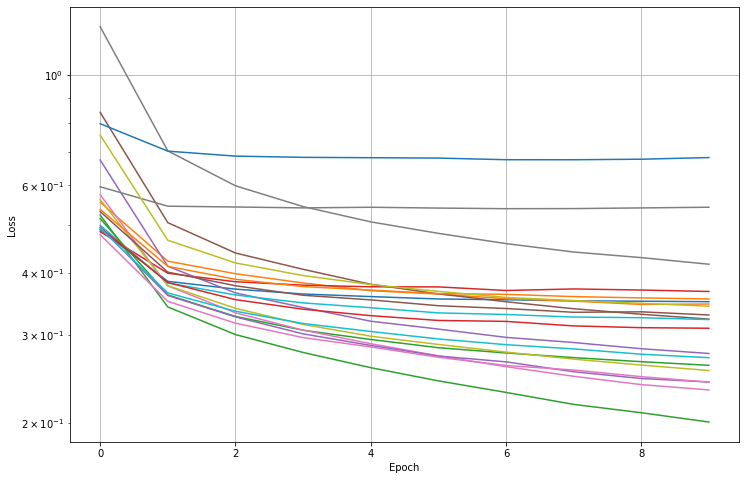

BEST MODEL HYPERPARAMETERS:
{'Ch1': 8, 'Ch2': 32, 'Nh': 128, 'drop': 0.23333333333333334, 'wd': 0.00031992671377973844, 'lr': 0.0011233240329780276, 'optim': 'sgd', 'epochs': 10}


In [17]:
plt.figure(figsize=(12,8))
for model in model_list:
    plt.semilogy(model['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()
print('BEST MODEL HYPERPARAMETERS:')
print(model_list[best_model]['hp_dict'])

## Best Model
***
Let's initialize a Network with the the best hyperparameter found by GridSearch.
Then I will train it and later tests it's performances.

In [24]:
best_net, best_params = ModelFromHP(ConvNet, model_list[best_model]['hp_dict'], device)

Network initialized


AVG.TRAIN.LOSS    AVG.VAL.LOSS    EPOCH


0.21414739         0.25355113       9: 100%|██████████| 10/10 [03:40<00:00, 22.05s/it]


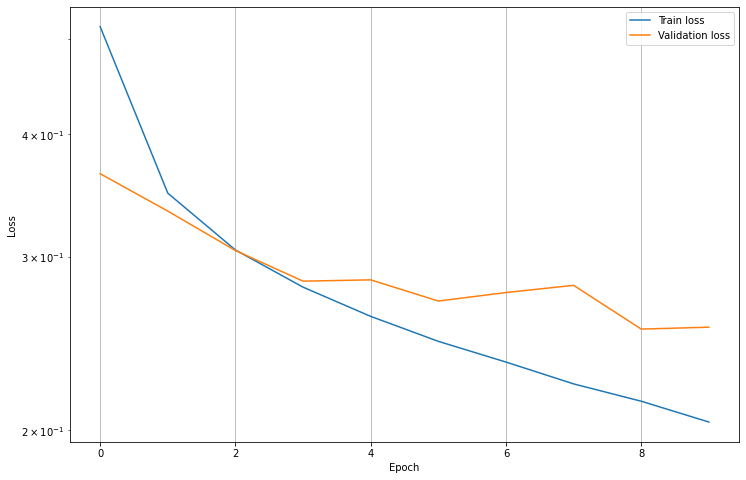

In [25]:
best_train_loss, best_val_loss = best_net.run_training(train_dataset, best_params, val_dataset=0.2, plot=True)

In [28]:
best_predict, best_label = best_net.run_test(test_dataset, best_params)

Accuracy of the network on the 10000 test images: 90 %


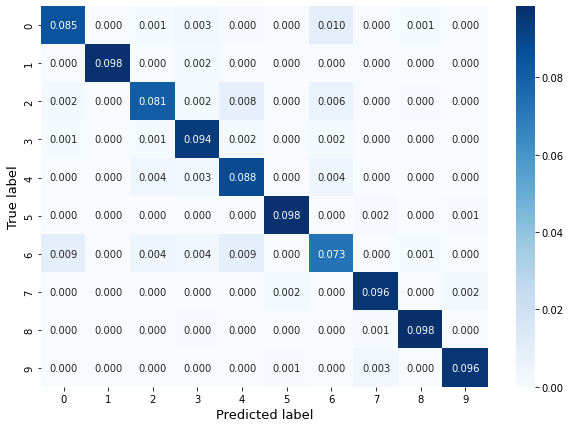

In [31]:
plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix(best_label, best_predict), annot=True, fmt =  "1.3f" , cmap="Blues" )
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
plt.show()

Tuning the hyperparameters allowed the Network to increase it's accuracy by 2%.
It is worth to mention that due to computational constrain the space of configuration explored was pretty small so we are probably just in a local minimum and there is a better configuration of hyperparameters.


## Weight Analysis
***

In this sction I will explore the filters of the convolutional layers as well as the weight distribution of the linear layer.

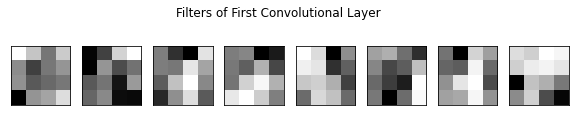

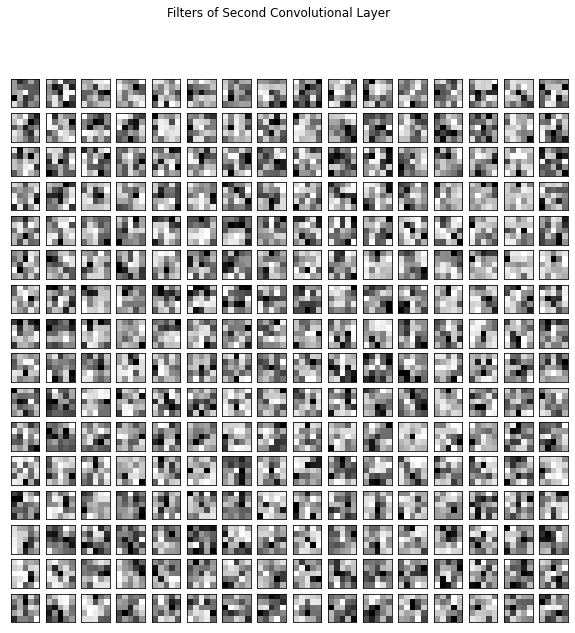

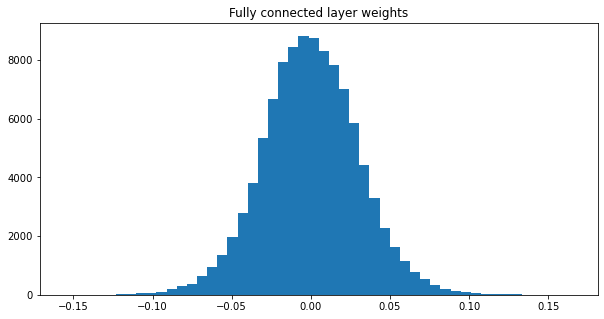

In [30]:
# First hidden layer
Conv1_w = best_net.convBlock1[0].weight.data.cpu().numpy()
Conv2_w = best_net.convBlock2[0].weight.data.cpu().numpy()
FC_w    = best_net.fcBlock[0].weight.data.cpu().numpy()
Ch1=8
Ch2=32
fig, ax = plt.subplots(1,Ch1, figsize=(10, 2))
for i in range(Ch1):
    ax[i].imshow(Conv1_w[i, 0, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])  
fig.suptitle('Filters of First Convolutional Layer ', fontsize = 12)
plt.show()

fig, ax = plt.subplots(16,16, figsize=(10,10))
for i in range(Ch2*8):
    ax[i//16,i%16].imshow(Conv2_w[i//8, i%8, :, :], cmap='Greys')
    ax[i//16,i%16].set_xticks([])
    ax[i//16,i%16].set_yticks([])  
fig.suptitle('Filters of Second Convolutional Layer ', fontsize = 12)
plt.show()

plt.figure(figsize=(10,5))
plt.hist(FC_w.flatten(), 50)
plt.title('Fully connected layer weights')
plt.show()

The filters does not provide any incredible information. But it's worth mention that, looking at the filters of the first convolutional layer, they are black (with an high value) in diffentent spatial regions.
This could be interpreted by the fact that each filters is looking at different particular characteristics (edges, shape..) of the input image.

The weights of the fully connected linear layer are gaussian distributed around the origin.

## Activation Analysis
***

Now I want to visualize the activations of the different layers.

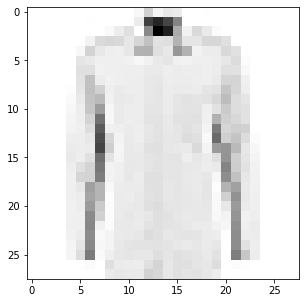

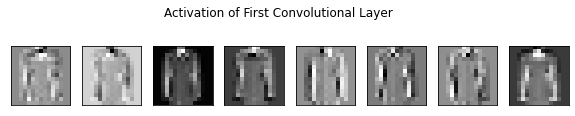

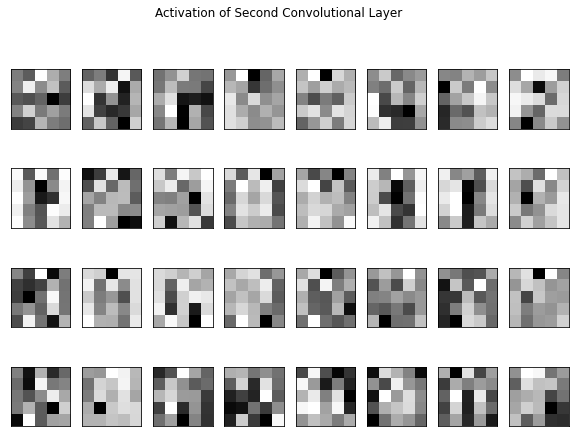

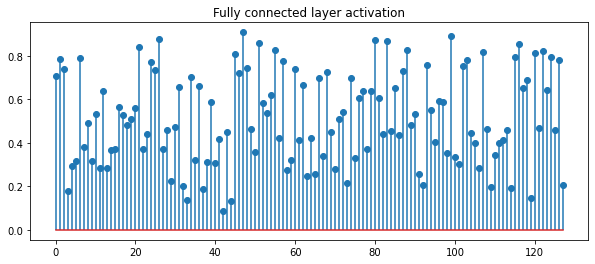

In [45]:
def get_activation1(layer, input, output):
    global activation1
    activation1 = torch.sigmoid(output)
def get_activation2(layer, input, output):
    global activation2
    activation2 = torch.sigmoid(output)
def get_activation3(layer, input, output):
    global activation3
    activation3 = torch.sigmoid(output)


### Register hook  
hook_handle1 = best_net.convBlock1[0].register_forward_hook(get_activation1)
hook_handle2 = best_net.convBlock2[0].register_forward_hook(get_activation2)
hook_handle3 = best_net.fcBlock[0].register_forward_hook(get_activation3)

### Analyze activations
best_net = best_net.to(device)
best_net.eval()
x = DataLoader(train_dataset, batch_size = 1, shuffle = True)
for batch in x:
    with torch.no_grad():
        x1 = batch[0].to(device)
        sample = x1.cpu().numpy()
        y1 = best_net(x1)
        z1 = (activation1, activation2, activation3)
    break

### Remove hook
hook_handle1.remove()
hook_handle2.remove()
hook_handle3.remove()

### Plot the image
fig = plt.figure(figsize=(5,5))
plt.imshow(sample.reshape((28,28)), cmap='Greys')
plt.show()
### Plot activations
fig, ax = plt.subplots(1,8, figsize=(10, 2))
for i in range(8):
    ax[i].imshow(z1[0][0, i, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])  
fig.suptitle('Activation of First Convolutional Layer ', fontsize = 12)
plt.show()

fig, ax = plt.subplots(4,8, figsize=(10, 7))
for i in range(8*4):
    ax[i//8,i%8].imshow(z1[1][0, i, :, :], cmap='Greys')
    ax[i//8,i%8].set_xticks([])
    ax[i//8,i%8].set_yticks([])  
fig.suptitle('Activation of Second Convolutional Layer ', fontsize = 12)
plt.show()

plt.figure(figsize=(10,4))
plt.stem(z1[2].cpu().numpy().flatten(), use_line_collection=True)
plt.title('Fully connected layer activation')
plt.show()

The activations of the first convolutional layer resembles the original image, while the activations of the second convolutional layer are no more "human readable".

Looking at the activation of the fully connected layer it can be seen that all the neurons are firing; this may means that the Network could have been trained for longer.